# Méthode de détection

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.flow import *
from clib.bellhop import *
import subprocess
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

### Profils de Méditerrannée

In [2]:
s = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='profiles')

In [3]:
c_med = s.SSP['mediterrannee']['c'][:,::10]
depth_med = s.SSP['mediterrannee']['depth'][::10]

### Profils Gulf Stream

In [4]:
g1 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': -61.2, \
                    'lat': 42., 'plot_map': False, 'contour':False}}, zmax = 4900)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc


In [5]:
g2 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': -66.6, \
                    'lat': 36., 'plot_map': False, 'contour': False}}, zmax = 4900)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc


In [6]:
c_gs = np.vstack((g1.SSP['gs']['c'], g2.SSP['gs']['c']))
depth_gs = np.vstack((g1.SSP['gs']['depth'], g2.SSP['gs']['depth']))

---
---
## Exemple du travail à faire sur un 1er profil

In [7]:
### Creat .env file

issp=0                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]
s.params['NDepth'] = 6
s.params['NRange'] = 11
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1.env' )


In [8]:
### read file .arr 
Arr1, Pos1 = s.read_arrivals_asc ('files/med1.arr', Narrmx = 2785)

Max.number of arrivals for source index 0 is 2783


In [9]:
### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos1['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos1['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  20


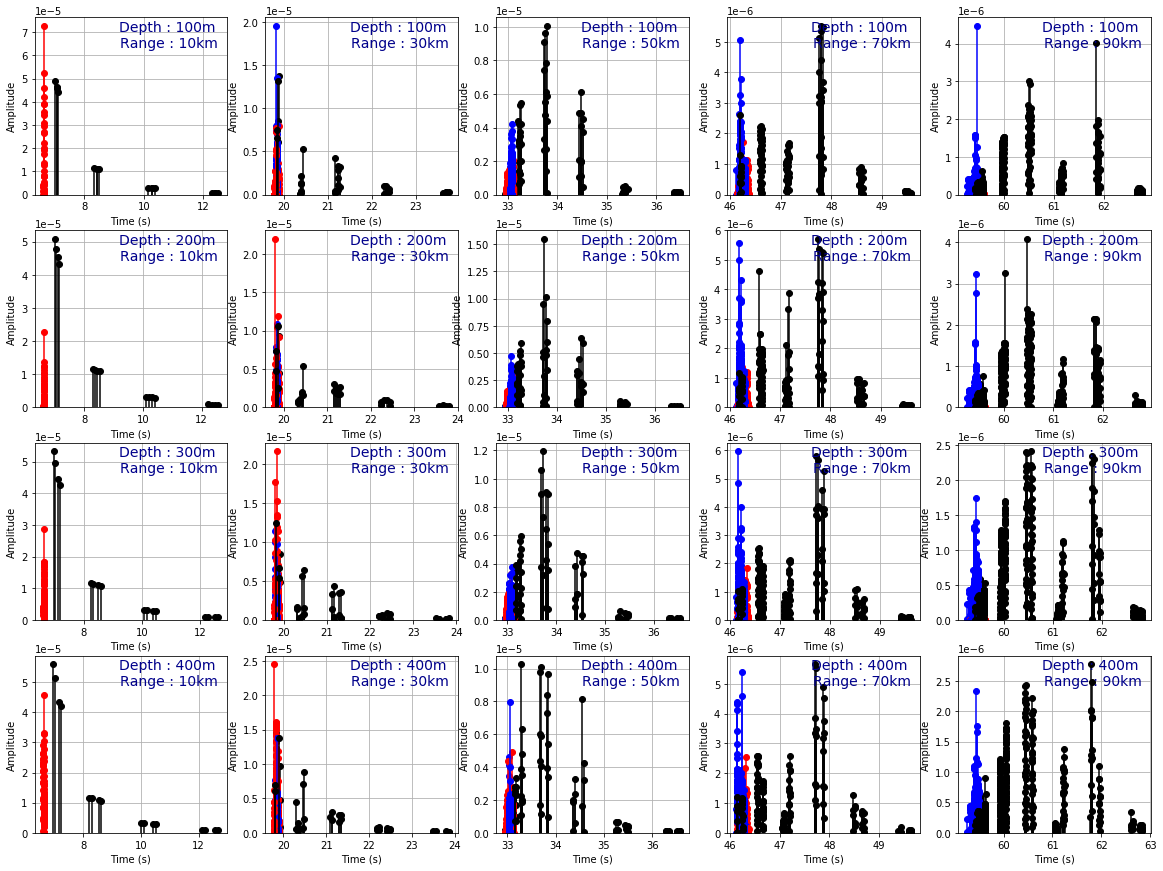

In [10]:
isd = 0       # choice of source depth

Total_time = []
Amp_min = []

plt.figure(figsize=(20,15))
k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1
        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        ax = plt.subplot(IRD.size,IRR.size,k)
        s.plotarr(Arr1, Pos1, irr, ird, isd)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-1, 2))
        plt.text(0.7, 0.9,'Depth : %dm \nRange : %.dkm' %(D[i],R[j]/1000.), horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes, fontsize=14, color='darkblue')
        plt.title('')
        plt.grid()
        
        Narr = int(Arr1['Narr'][irr,ird,isd])
        amp = Arr1['A'][irr,:Narr, ird, isd]
        Amp_min.append(np.min(abs(amp)))
        times = Arr1['delay'][irr, :Narr, ird, isd]
        Total_time.append(np.max(times)-np.min(times))

### ZOOM 

In [12]:
# sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

# SL - TL - NL + DI + PG  >  RL 

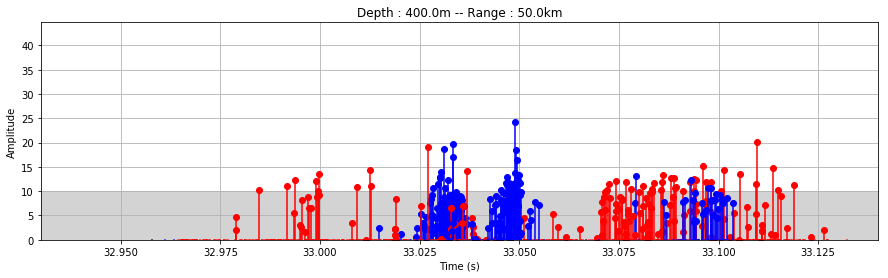

In [13]:
ird = 4       # depth : 300m    
irr = 5       # range : 50km  

plt.figure(figsize=(15,4))
ax = plt.subplot(111)
Narr = int(Arr1['Narr'][irr, ird, isd])
for i in range (Narr) : 
    t = Arr1['delay'][irr, i, ird, isd]
    TL = -20*np.log10 (abs(Arr1['A'][irr, i, ird, isd]))
    RL = SL - TL -NL +DI + PG
    markerline, stemlines, baseline = plt.stem( [t], [RL])            

    if np.logical_and ( Arr1['NumTopBnc'][irr, i,ird,isd] == 0, Arr1['NumBotBnc'][irr, i,ird,isd] == 0):
        plt.setp(stemlines, color = 'r')
        plt.setp(markerline, color = 'r')

    elif Arr1['NumBotBnc'][irr, i,ird,isd] == 0:
        plt.setp(stemlines, color = 'b')
        plt.setp(markerline, color = 'b')

    else : 
        plt.setp(stemlines, color = 'k')
        plt.setp(markerline, color = 'k')

plt.ylim(ymin=0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Source depth : %.1fm -- Receiver depth : %.1fm -- Receiver range : %.1fkm' \
#          % (Pos['s']['depth'][isd], Pos['r']['depth'][ird], Pos['r']['range'][irr]/1000.))
plt.title('Depth : %.1fm -- Range : %.1fkm' %(Pos1['r']['depth'][ird], Pos1['r']['range'][irr]/1000.))
plt.grid()
plt.xlim([32.93, 33.14])
#plt.xlim([33.025, 33.08])

ax.fill_between(np.array([0.,75.]), np.array([10., 10.]), facecolor='lightgrey')

---
## CHOIX de la méthode de détection : 1er rayon > 10 dB

In [14]:
isd = 0       # choice of source depth

TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr1['Narr'][irr,ird,isd])
        amp = Arr1['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr1['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        t_first = np.min(t_ok)
        idx_first = np.where(times==t_first)[0][0]
        
        # Chosen ray features
        NumTopBnc_f = Arr1['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
        NumBotBnc_f = Arr1['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
        SrcAngle_f  = Arr1['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
        # Appends
        TopBnc.append(NumTopBnc_f)
        BotBnc.append(NumBotBnc_f)
        SrcAngle.append(SrcAngle_f)

In [15]:
n = R.size
print('SrcAngle : \n')
print ('                  10km          30km         50km         70km         90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :  %.5f°    %.5f°    %.5f°    %.5f°    %.5f°' %(D[i], SrcAngle[n*i], \
                                                                        SrcAngle[n*i+1], SrcAngle[n*i+2], \
                                                                        SrcAngle[n*i+3], SrcAngle[n*i+4]))

SrcAngle : 

                  10km          30km         50km         70km         90km

  Depth = 100m :  2.34520°    0.60505°    -6.07551°    -10.11584°    -8.04567°
  Depth = 200m :  2.03517°    -0.88507°    -1.80515°    -10.20585°    -8.03567°
  Depth = 300m :  0.48504°    -0.73506°    0.88507°    -10.19585°    8.41570°
  Depth = 400m :  -1.33511°    -0.73506°    -0.99508°    10.84590°    8.70573°


In [16]:
k = True
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k = False
print ('Pas de réfélchis fond : %s.' %k)

Pas de réfélchis fond : True.


In [17]:
n = R.size
print('TopBnc : \n')
print ('                 10km     30km     50km     70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], TopBnc[n*i], \
                                                                        TopBnc[n*i+1], TopBnc[n*i+2], \
                                                                        TopBnc[n*i+3], TopBnc[n*i+4]))

TopBnc : 

                 10km     30km     50km     70km     90km

  Depth = 100m :   0        0        2        2        3
  Depth = 200m :   0        0        0        2        3
  Depth = 300m :   0        0        0        2        2
  Depth = 400m :   0        0        0        1        2


In [19]:
#ird = 2   # *100 = depth (m)
#irr = 9   # *10 = range (km)

Dist = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*100.)[0][0]
        idx_r = np.where(R==irr*10.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos1['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos1['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
        else :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
        
        Dist.append(dist)


In [20]:
n = R.size
print('Distance : \n')
print ('                 10km     30km     50km     70km     90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %d        %d        %d        %d        %d' %(D[i], Dist[n*i], \
                                                                        Dist[n*i+1], Dist[n*i+2], \
                                                                        Dist[n*i+3], Dist[n*i+4]))

Distance : 

                 10km     30km     50km     70km     90km

  Depth = 100m :   10009        30044        50112        70407        90357
  Depth = 200m :   10011        30042        50057        70419        90354
  Depth = 300m :   10014        30046        50072        70412        90347
  Depth = 400m :   10010        30046        50068        70436        90366


In [21]:
mean_d = np.array([10011., 30044.5, 50077.2, 70418.5, 90356.])
real_d = np.array([10., 30., 50., 70., 90.])*1000.

res = np.polyfit(real_d,mean_d,1)         # res[0] = slope

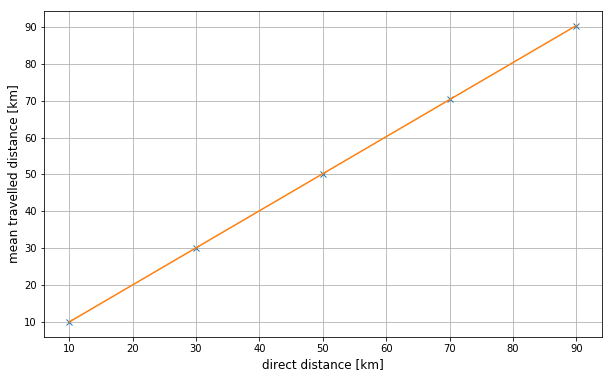

In [22]:
plt.figure(figsize=(10,6))
plt.plot (real_d/1000., mean_d/1000., 'x')
yreg = res[0]*real_d + res[1]
plt.plot(real_d/1000., yreg/1000.)
plt.xlabel('direct distance [km]',fontsize=12)
plt.ylabel('mean travelled distance [km]',fontsize=12)
plt.grid()


In [23]:
Diff=np.zeros_like(Dist)
for i in range (R.size) : 
    dreal = Dist[i::R.size]
    dmean = res[0]*R[i] + res[1]
    diff = dreal - dmean 
    Diff[i::R.size]= diff

In [24]:
n = R.size
print('Diff : \n') 
print ('                    10km          30km          50km          70km           90km\n')
for i in range(D.size) :  
    print('  Depth = %dm :   %.2fm        %.2fm       %.2fm       %.2fm        %.2fm' %(D[i], Diff[n*i], \
                                                                        Diff[n*i+1], Diff[n*i+2], \
                                                                        Diff[n*i+3], Diff[n*i+4]))

Diff : 

                    10km          30km          50km          70km           90km

  Depth = 100m :   41.20m        -30.12m       -69.10m       119.65m        -37.08m
  Depth = 200m :   42.54m        -32.26m       -124.17m       131.37m        -39.51m
  Depth = 300m :   45.48m        -28.45m       -108.79m       124.82m        -47.24m
  Depth = 400m :   41.67m        -28.45m       -112.76m       148.71m        -28.15m


---
---
---
# Avec plus de vignettes (19x9)

In [25]:
### Creat .env file

issp=0                          # sound speed profile number
s.params['file_type'] = 'A'
s.params['ALimites'] = [-60.0, 60.0]

s.params['zmin'] = 0.
s.params['rmin'] = 0.
s.params['NDepth'] = 11
s.params['NRange'] = 21
s.params['NBeams'] = 12000

s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_complete.env' )

In [26]:
### read file .arr 
Arr2, Pos2 = s.read_arrivals_asc ('med1_complete.arr', Narrmx = 2786)

Max.number of arrivals for source index 0 is 2783


In [27]:
### Reponses impulsionnelles
D = np.arange(50., 450.+1., 50.)         # tous les 50m
R = np.arange(5., 95.+1., 5.)* 1000.     # tous les 5km
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)

### Indices correspondants aux récepteurs choisis
IRD = np.zeros_like(D)
for i in range (D.size) : 
    IRD[i] = np.where(Pos2['r']['depth']==D[i])[0][0]
    
IRR = np.zeros_like(R)
for i in range (R.size) : 
    IRR[i] = np.where(Pos2['r']['range']==R[i])[0][0]

Nombre total de réponses impulsionnelles :  171


In [28]:
# 1er rayon supérieur à 10dB

isd = 0       # choice of source depth

Tarr = []
TopBnc = []
BotBnc = []
SrcAngle = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        
        # Received level
        Narr = int(Arr2['Narr'][irr,ird,isd])
        amp = Arr2['A'][irr,:Narr, ird, isd]
        TL = -20*np.log10 (abs(amp))
        RL = SL - TL -NL +DI + PG
        
        # Times
        times = Arr2['delay'][irr, :Narr, ird, isd]
        idx = np.where(RL > 10.)
        t_ok = times[idx]
        if len(t_ok) != 0 : 
            t_first = np.min(t_ok)
        
            idx_first = np.where(times==t_first)[0][0]
        
            # Chosen ray features
            NumTopBnc_f = Arr2['NumTopBnc'][irr, :Narr, ird, isd][idx_first]
            NumBotBnc_f = Arr2['NumBotBnc'][irr, :Narr, ird, isd][idx_first]
            SrcAngle_f  = Arr2['SrcAngle'][irr, :Narr, ird, isd][idx_first]
        
            # Appends
            TopBnc.append(NumTopBnc_f)
            BotBnc.append(NumBotBnc_f)
            SrcAngle.append(SrcAngle_f)
            Tarr.append(t_first)
            
        else : 
            TopBnc.append(np.NaN)
            BotBnc.append(np.NaN)
            SrcAngle.append(np.NaN)
            Tarr.append(np.NaN)
            

In [29]:
k = 0
for i in range(len(BotBnc)) : 
    if BotBnc[i]!= 0. : 
        k += 1
print ('Nombre de réfélchis fond : %d/%d.' %(k, len(BotBnc)))

Nombre de réfélchis fond : 4/171.


In [30]:
Dist = []

k = 0
for i in range (IRD.size):
    for j in range(IRR.size):
        k+=1

        ird = int(IRD[i])     # choice of receiver depth
        irr = int(IRR[j])     # choice of receiver range
        

        # angle surlequel on travaille

        idx_d = np.where(D==ird*50.)[0][0]
        idx_r = np.where(R==irr*5.*1000.)[0][0]
        angle = SrcAngle[R.size*idx_d + idx_r]

        ### Creat .env file E

        issp=0                          # sound speed profile number
        s.params['file_type'] = 'E'
        s.params['ALimites'] = [angle]

        s.params['zmin'] = Pos2['r']['depth'][ird]          # receiver depth (m)
        s.params['rmin'] = Pos2['r']['range'][irr]/1000.    # receiver range (km)  

        s.params['NDepth'] = 1
        s.params['NRange'] = 1
        s.params['NBeams'] = 2

        s.generate_envfile('mediterrannee',Issp=issp, SSP_depth_step=10, file_env = 'med1_E.env' )
        
        ### execute bellhop
        subprocess.call(["bellhop.exe", 'med1_E'])
        
        ### output .ray file
        dictE = s.plotE ('med1_E.ray', plot = False)
        angles_E = dictE['SrcAngle']
        

        ### distance correspondante  
        if angles_E.size == 1 : 
            dist = dictE['Dist'][0]
        
        elif angles_E.size ==2 :
            dist = dictE['Dist'][np.where(angles_E !=0.)][0]
        
        else :
            dist = np.NaN
        
        Dist.append(dist)
        
Dist = np.array(Dist)

In [32]:
#Dist[np.isnan(Dist)].size / Dist.size *100.

In [33]:
REAL_RANGE = np.zeros(D.size*R.size)
for k in range (D.size) :
    REAL_RANGE[k*R.size:(k+1)*R.size]=R

---
### Découpé en plusieurs parties 

In [35]:
### A mettre à jour pour pouvoir travailler avec de NaN...
TT = np.array(Tarr)
Dist = np.array(Dist)

idx1 = np.where(REAL_RANGE <= 30.*1000.)[0]
idx2 = np.where(REAL_RANGE > 60.*1000.)[0]
         
res1_test1 = np.polyfit(TT[idx1], Dist[idx1],1)
#Distn = Dist[~np.isnan(Dist)]
#TTn   = TT[~np.isnan(Dist)]
res1_test2 = np.polyfit(TT[idx2], Dist[idx2],1)

res_test1 = np.polyfit(REAL_RANGE[idx1],Dist[idx1],1)
res_test2 = np.polyfit(REAL_RANGE[idx2], Dist[idx2],1)

In [36]:
Range_reg_30 = res_test1[0] * (res1_test1[0]*TT[idx1] )#+ res1_test1[1]) + res_test1[1]

In [37]:
Range_reg_30.size

54

In [38]:
ddd = REAL_RANGE[idx1] - Range_reg_30

In [39]:
np.mean(abs(ddd))

29.724049001140244

In [40]:
Range_reg_100 = res_test2[0] * (res1_test2[0]*TT[idx2] )#+ res1_test1[1]) + res_test1[1]

In [41]:
Range_reg_100.size

63

In [42]:
ddd100 = REAL_RANGE[idx2] - Range_reg_100

In [43]:
np.mean(abs(ddd100[~np.isnan(ddd100)]))

60.084149754439764

---
### En une seule partie 

In [44]:
res1 = np.polyfit(Tarr, Dist, 1)

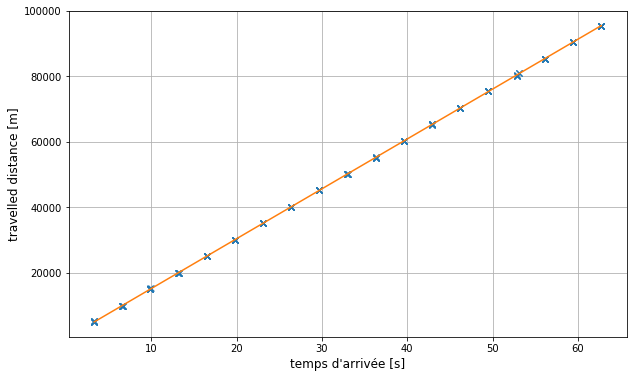

In [45]:
TT = np.array(Tarr)

plt.figure(figsize=(10,6))
plt.plot (TT, Dist, 'x')
yreg = res1[0]*TT + res1[1]
plt.plot(TT, yreg)
plt.xlabel("temps d'arrivée [s]",fontsize=12)
plt.ylabel('travelled distance [m]',fontsize=12)
plt.grid()

In [46]:
Dmean = []
for k in range (R.size) :
    Dmean.append(np.mean(Dist[k::R.size]))
Dmean=np.array(Dmean)

In [47]:
res = np.polyfit(R,Dmean,1)         # res[0] = slope

(0.0, 40.0)

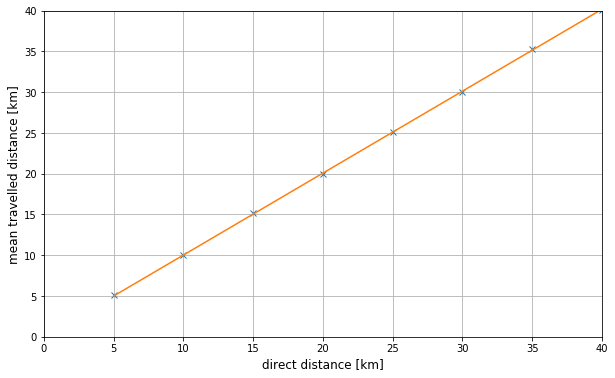

In [48]:
RR = np.array(R)

plt.figure(figsize=(10,6))
plt.plot (RR/1000., Dmean/1000., 'x')
yreg = res[0]*RR + res[1]
plt.plot(RR/1000., yreg/1000.)
plt.xlabel('direct distance [km]',fontsize=12)
plt.ylabel('mean travelled distance [km]',fontsize=12)
plt.grid()
plt.xlim([0., 40.])
plt.ylim([0., 40.])

In [49]:
Range_reg = res[0] * (res1[0]*TT )   #+ res1[1]) + res[1]

In [50]:
DIFF = Range_reg - REAL_RANGE

In [51]:
np.max(abs(DIFF))

1104.7999736795464

In [54]:
DIFF_30 = DIFF[np.where(REAL_RANGE <=30.*1000.)[0]]
np.max(abs(DIFF_30))

299.3622297446527

---
----
---

## Idées ...

In [ ]:
# écrire les .env
# executer bellhop
# lire les .arr et tracer les 20 (ou plus) vignettes

# trouver la tendance
# définir des zones
# faire des stats 


# trajectoire effectuée par le rayon (lancer eigenrays E, puis calcul de la distance)
# quelle erreur si trajectoire approximée à une trajectoire directe par exemple ? 

In [ ]:
## conclusion : y a-t-il des méthodes de détection privilégiées ? 

In [ ]:
# Quelle erreur si mauvaise détection ? 
# Quelle conséquence si paquet et pas rayon isolé ? 
# 